**1. Load the Dataset using PySpark**

In [5]:
# Initializing Spark session

!pip install -q findspark

import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Spotify User Graph") \
    .getOrCreate()

spark

In [6]:
# Loading the datasets

nodes = spark.read.csv("/content/nodes.csv", header=True, inferSchema=True)
edges = spark.read.csv("/content/edges.csv", header=True, inferSchema=True)

In [7]:
# Exploratory Analysis

print("Nodes:")
nodes.printSchema()

print("Edges:")
edges.printSchema()

print("Number of nodes:", nodes.count())
print("Number of edges:", edges.count())

nodes.show(5)
edges.show(5)

Nodes:
root
 |-- spotify_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- followers: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- genres: string (nullable = true)
 |-- chart_hits: string (nullable = true)

Edges:
root
 |-- id_0: string (nullable = true)
 |-- id_1: string (nullable = true)

Number of nodes: 156422
Number of edges: 300386
+--------------------+------------------+---------+----------+--------------------+--------------------+
|          spotify_id|              name|followers|popularity|              genres|          chart_hits|
+--------------------+------------------+---------+----------+--------------------+--------------------+
|48WvrUGoijadXXCsG...|         Byklubben|   1738.0|      24.0|['nordic house', ...|          ['no (3)']|
|4lDiJcOJ2GLCK6p9q...|          Kontra K|1999676.0|      72.0|['christlicher ra...|['at (44)', 'de (...|
|652XIvIBNGg3C0KIG...|             Maxim|  34596.0|      36.0|                  []|     

**2. Create the Graph using NetworkX**

In [8]:
from pyspark.sql.functions import col, sum as _sum
import networkx as nx

print("Nodes schema")
nodes.printSchema()

print("Edges schema")
edges.printSchema()

num_nodes = nodes.count()
num_edges = edges.count()

print(f"Number of nodes (artists): {num_nodes}")
print(f"Number of edges (collaborations): {num_edges}")

G = nx.Graph()

for row in edges.select("id_0", "id_1").collect():
    G.add_edge(row["id_0"], row["id_1"])

print("Number of nodes in G:", G.number_of_nodes())
print("Number of edges in G:", G.number_of_edges())

nodes_numeric = (nodes.withColumn("followers_num", col("followers").cast("double"))
    .withColumn("popularity_num", col("popularity").cast("double"))
)

print("Statistics for followers & popularity")
nodes_numeric.select("followers_num", "popularity_num").describe().show()

missing_nodes = nodes_numeric.select(
    _sum(col("followers_num").isNull().cast("int")).alias("missing_followers"),
    _sum(col("popularity_num").isNull().cast("int")).alias("missing_popularity"),
    _sum(col("name").isNull().cast("int")).alias("missing_name")
)

print("Missing values in nodes")
missing_nodes.show()

missing_edges = edges.select(
    _sum(col("id_0").isNull().cast("int")).alias("missing_id_0"),
    _sum(col("id_1").isNull().cast("int")).alias("missing_id_1")
)

print("Missing values in edges")
missing_edges.show()

Nodes schema
root
 |-- spotify_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- followers: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- genres: string (nullable = true)
 |-- chart_hits: string (nullable = true)

Edges schema
root
 |-- id_0: string (nullable = true)
 |-- id_1: string (nullable = true)

Number of nodes (artists): 156422
Number of edges (collaborations): 300386
Number of nodes in G: 153327
Number of edges in G: 300386
Statistics for followers & popularity
+-------+-----------------+------------------+
|summary|    followers_num|    popularity_num|
+-------+-----------------+------------------+
|  count|           156417|            156422|
|   mean|86224.26419762558|21.157497027272377|
| stddev| 940103.106174187|18.338289529604182|
|    min|              0.0|               0.0|
|    max|     1.02156853E8|             100.0|
+-------+-----------------+------------------+

Missing values in nodes
+-----------------+-----------

**3. Visualize the subset of the graph using NetworkX**

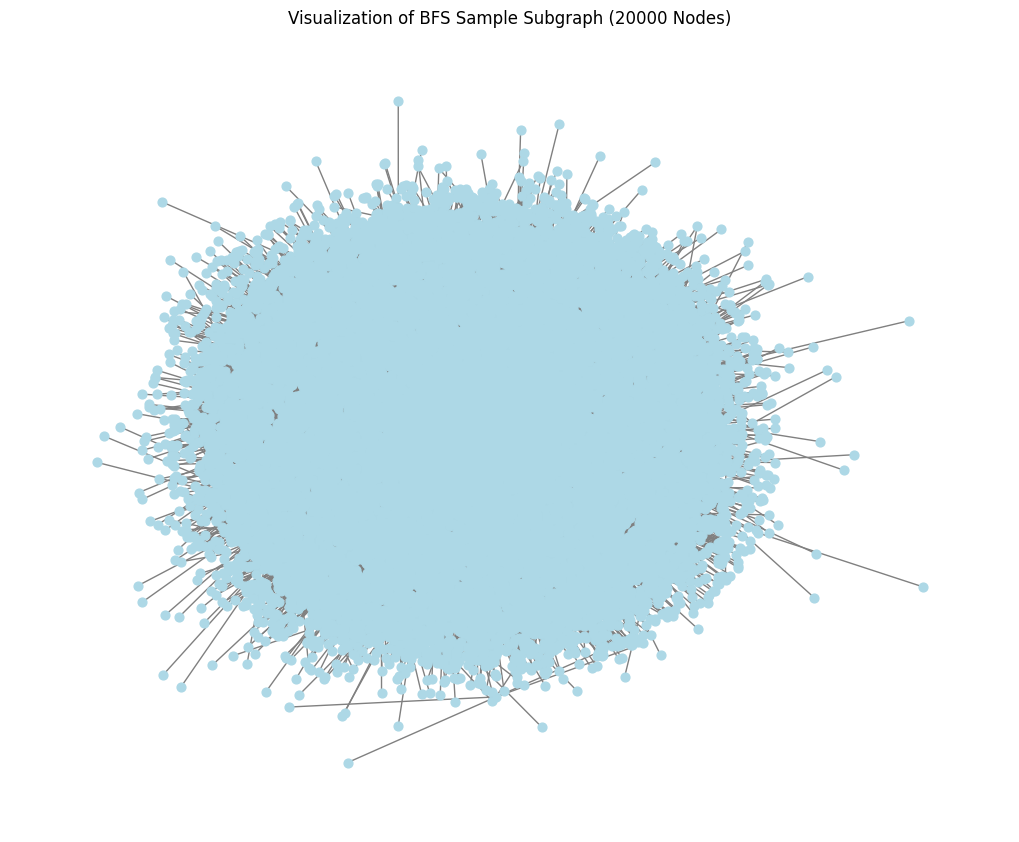

In [ ]:
# I'm extracting the graph subsample using NetworkX's Breadth First Search Method.
# I took reference for BFS sampling from official NetworkX Github repository - BFS traversal methods:
# Citation: NetworkX Team (2023), https://github.com/networkx/networkx/blob/main/networkx/algorithms/traversal/breadth_first_search.py

import random
import matplotlib.pyplot as plt
from collections import deque

start = random.choice(list(G.nodes()))

def bfs_sample(graph, start_node, limit=20000):
    visited = set()
    queue = deque([start_node])

    while queue and len(visited) < limit:
        node = queue.popleft()
        if node not in visited:
            visited.add(node)
            for neighbor in graph.neighbors(node):
                queue.append(neighbor)

    return graph.subgraph(visited).copy()

G_sub = bfs_sample(G, start, limit=20000)

plt.figure(figsize=(10, 8))

pos = nx.spring_layout(G_sub, seed=42)

nx.draw(
    G_sub,
    pos,
    node_size=40,
    node_color="lightblue",
    edge_color="gray",
    with_labels=False
)

plt.title("Visualization of BFS Sample Subgraph (20000 Nodes)")
plt.show()


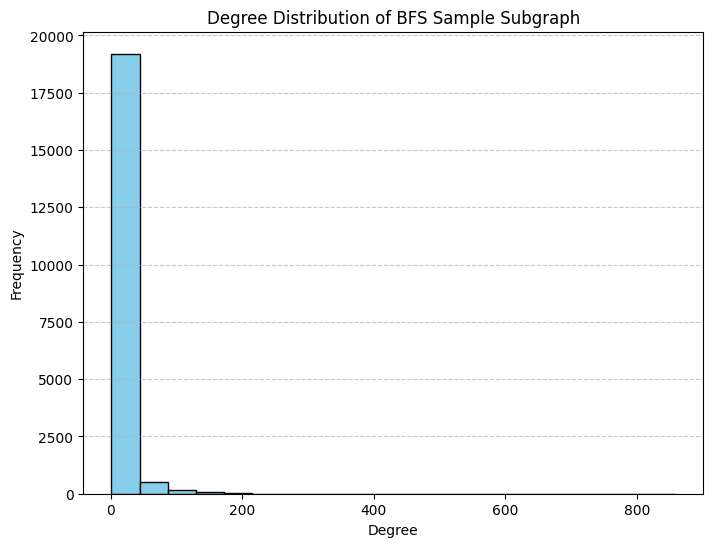

In [ ]:
import matplotlib.pyplot as plt

# Compute degrees for each node in the subgraph
degrees = [deg for _, deg in G_sub.degree()]

plt.figure(figsize=(8, 6))
plt.hist(degrees, bins=20, color="skyblue", edgecolor="black")

plt.title("Degree Distribution of BFS Sample Subgraph")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


**4. Compute Network Properties**

In [ ]:
import networkx as nx

print("Computing centrality measures on Graph Subsample")

centralities = {
    "Degree Centrality": nx.degree_centrality(G_sub),
    "Betweenness Centrality": nx.betweenness_centrality(G_sub),
    "Closeness Centrality": nx.closeness_centrality(G_sub),
    "Eigenvector Centrality": nx.eigenvector_centrality(G_sub, max_iter=500),
    "PageRank": nx.pagerank(G_sub)
}

Computing centrality measures on Graph Subsample


**Top 5 Most Influential Artists**

In [ ]:
from pyspark.sql import Row

rows = []
for node in G_sub.nodes():
    rows.append(Row(
        spotify_id=node,
        degree=centralities["Degree Centrality"][node],
        betweenness=centralities["Betweenness Centrality"][node],
        closeness=centralities["Closeness Centrality"][node],
        eigenvector=centralities["Eigenvector Centrality"][node],
        pagerank=centralities["PageRank"][node]
    ))

centrality_df = spark.createDataFrame(rows)

# Join with nodes to get artist names
name_centrality = centrality_df.join(nodes, on="spotify_id", how="left")

print("Top 5 artists by degree:")
name_centrality.select("name", "degree").orderBy("degree", ascending=False).show(5, truncate=False)

print("Top 5 artists by betweenness:")
name_centrality.select("name", "betweenness").orderBy("betweenness", ascending=False).show(5, truncate=False)

print("Top 5 artists by closeness:")
name_centrality.select("name", "closeness").orderBy("closeness", ascending=False).show(5, truncate=False)

print("Top 5 artists by eigenvector:")
name_centrality.select("name", "eigenvector").orderBy("eigenvector", ascending=False).show(5, truncate=False)

print("Top 5 artists by pagerank:")
name_centrality.select("name", "pagerank").orderBy("pagerank", ascending=False).show(5, truncate=False)

Top 5 artists by degree:
+----------+--------------------+
|name      |degree              |
+----------+--------------------+
|Mc Gw     |0.04290214510725536 |
|MC MN     |0.031601580079003946|
|Gucci Mane|0.02545127256362818 |
|Steve Aoki|0.02490124506225311 |
|Snoop Dogg|0.02475123756187809 |
+----------+--------------------+
only showing top 5 rows

Top 5 artists by betweenness:
+-----------+--------------------+
|name       |betweenness         |
+-----------+--------------------+
|MC Lan     |0.08761227481056148 |
|Mc Gw      |0.0833669670084574  |
|Anitta     |0.04838921904669424 |
|Major Lazer|0.045480066137310336|
|Diplo      |0.04430684973099255 |
+-----------+--------------------+
only showing top 5 rows

Top 5 artists by closeness:
+-----------+------------------+
|name       |closeness         |
+-----------+------------------+
|MC Lan     |0.3555504195704736|
|Anitta     |0.3522377018863272|
|Major Lazer|0.3444006268404829|
|Diplo      |0.3417814540110059|
|R3HAB      |0.

**5. Predicting User Popularity Using PySpark**

**Linear Regression Model**

In [ ]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# Join centralities with followers, popularity and name
data = centrality_df.join(
    nodes.select("spotify_id", "name", "followers", "popularity"),
    on="spotify_id",
    how="inner"
)

data = (
    data.withColumn("followers",  col("followers").cast("double"))
        .withColumn("popularity", col("popularity").cast("double"))
)

data = data.select("spotify_id", "name", "followers", "degree", "betweenness", "closeness", "eigenvector", "pagerank", "popularity").dropna()

# Assemble features
assembler = VectorAssembler(
    inputCols=["followers", "degree", "betweenness", "closeness", "eigenvector", "pagerank"],
    outputCol="features"
)

data_with_features = assembler.transform(data)

# Train–Test split (80% train, 20% test)
train_data, test_data = data_with_features.randomSplit([0.8, 0.2], seed=42)
print("Training rows:", train_data.count())
print("Testing rows:", test_data.count())

# Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="popularity")
lr_model = lr.fit(train_data)

test_predictions = lr_model.transform(test_data)

test_predictions.select("spotify_id", "name", "prediction", "popularity").show(10, truncate=False)

Training rows: 16120
Testing rows: 3891
+----------------------+----------------+------------------+----------+
|spotify_id            |name            |prediction        |popularity|
+----------------------+----------------+------------------+----------+
|002eDhqXlxtQHdaIKXyf3H|Blaklez         |21.352886557302483|27.0      |
|00Jb0oU8RUPJgKTWKsNCxw|A Travestis     |28.70731778765507 |27.0      |
|00TGpdWW8QznHxm6cmIqtK|DJ Gabriel Souza|25.72922315327068 |4.0       |
|00Ybe80NUTFFjRA344FuVI|Si              |16.114910627473122|4.0       |
|00taSe6u4o0o7AqwErRhhM|Christina Valemi|28.124083221696566|24.0      |
|00yIvEQBsJzGzaB9pMF8RG|MC AK           |23.74595387367077 |38.0      |
|01988BWUnQiclJ70TTcnOq|Symba           |28.849845043381308|19.0      |
|01P95MsV6kbRUvHnnLsldG|Malharo         |26.14331417086308 |24.0      |
|01mvWXVNW6Gz5Oxf6bQrtM|Heimanu         |21.633339978620782|39.0      |
|01nUdqwuIHCHLZNP2TvYVF|Boy Wonder CF   |37.69555781196699 |57.0      |
+----------------------+

**Print Model Coefficients and Intercept**

In [ ]:
feature_names = ["followers", "degree", "betweenness", "closeness", "eigenvector", "pagerank"]

print("followers:", lr_model.coefficients[0])
print("degree:", lr_model.coefficients[1])
print("betweenness:", lr_model.coefficients[2])
print("closeness:", lr_model.coefficients[3])
print("eigenvector:", lr_model.coefficients[4])
print("pagerank:", lr_model.coefficients[5])

print("\nIntercept:", lr_model.intercept)

followers: 1.3980373667017511e-06
degree: 15808.103893319207
betweenness: -2458.4261125963894
closeness: 351.25644347391625
eigenvector: -640.0839048449207
pagerank: -59493.0398096729

Intercept: -54.81305152680301


**Evaluate Model Performance**

In [ ]:
training_summary = lr_model.summary

print("RMSE (Root Mean Squared Error):", training_summary.rootMeanSquaredError)
print("R² (Coefficient of Determination):", training_summary.r2)

RMSE (Root Mean Squared Error): 17.62430652878376
R² (Coefficient of Determination): 0.35862392449175284


**6. Cluster Users Based on Their Characteristics Using PySpark**

**Perform K-Means Clustering and optimal number of clusters**

K = 2
Within Set Sum of Squared Errors (WSSSE): 80865.07277292926
------------------------------------------------------------
K = 3
Within Set Sum of Squared Errors (WSSSE): 68112.07197038343
------------------------------------------------------------
K = 4
Within Set Sum of Squared Errors (WSSSE): 54450.95761055014
------------------------------------------------------------
K = 5
Within Set Sum of Squared Errors (WSSSE): 44916.3615795972
------------------------------------------------------------
K = 6
Within Set Sum of Squared Errors (WSSSE): 42380.71989891658
------------------------------------------------------------
K = 7
Within Set Sum of Squared Errors (WSSSE): 37052.25936203297
------------------------------------------------------------


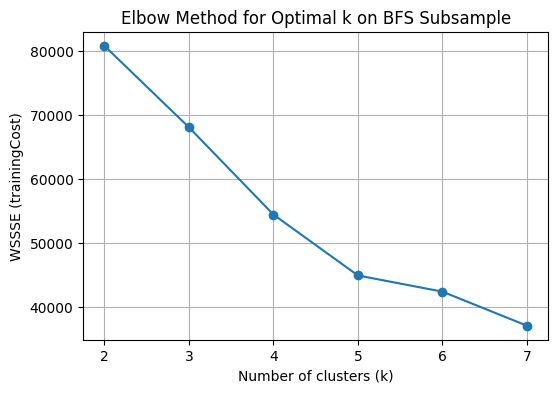


Cluster sizes for K = 6:
+----------+-----+
|prediction|count|
+----------+-----+
|         1|    2|
|         3|   40|
|         5| 1582|
|         4|  209|
|         2|   29|
|         0|18149|
+----------+-----+

+----------------------+----------------+----------+
|spotify_id            |name            |prediction|
+----------------------+----------------+----------+
|1HvYwEbfOUhm2F4g9nH0vP|Joey Galaxy     |0         |
|3M9kwkgeTQZ4v5hf9joTiB|Mc LDM          |0         |
|6dWrS7Dgecyvff4LHvKXy1|DJ GB do Dick   |0         |
|0GiOY1iWqsrsKXh6lCP1gx|Fatty Duke      |0         |
|4PXThoWa6Eg0a1Cui7KJee|Willy Rodríguez |0         |
|6vWJqqdJ9WNOPqo1CqGtkG|Mc Rkostta      |0         |
|5Wg2b4Mp42gicxEeDNawf7|A7S             |5         |
|0cCwzcNOFDj2M4n0nlWeDC|DJ Cezão da Vila|0         |
|6YxFjFFWCZnHZD9MANJdRV|Ratinn          |0         |
|0Soy4hLjEDPZ74GFJ7Ybqg|Cap Dre         |0         |
+----------------------+----------------+----------+
only showing top 10 rows



In [ ]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withStd=True,
    withMean=False
)

scalerModel = scaler.fit(data_with_features)
cluster_data = scalerModel.transform(data_with_features).cache()

# I used Elbow method on the graph sample to find the optimal number of clusters
k_values = []
wssse_values = []

for k in [2, 3, 4, 5, 6, 7]:
    kmeans = KMeans(
        featuresCol="scaledFeatures",
        predictionCol="prediction",
        k=k,
        maxIter=15,
        seed=42
    )
    model = kmeans.fit(cluster_data)

    wssse = model.summary.trainingCost
    k_values.append(k)
    wssse_values.append(wssse)

    print(f"K = {k}")
    print("Within Set Sum of Squared Errors (WSSSE):", wssse)

# Plotting elbow curve
plt.figure(figsize=(6, 4))
plt.plot(k_values, wssse_values, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("WSSSE (trainingCost)")
plt.title("Elbow Method for Optimal Clusters")
plt.grid(True)
plt.show()

# I picked k=6 based on the elbow plot
k_final = 6

kmeans_final = KMeans(
    featuresCol="scaledFeatures",
    predictionCol="prediction",
    k=k_final,
    maxIter=15,
    seed=42
)

model_final = kmeans_final.fit(cluster_data)

print(f"\nCluster sizes for K = {k_final}:")
model_final.transform(cluster_data).groupBy("prediction").count().show()

clustered_users = model_final.transform(cluster_data)
clustered_users.select("spotify_id", "name", "prediction").show(10, truncate=False)